In [1]:
from storm_analysis.daostorm_3d.mufit_analysis import analyze
import storm_analysis.sa_library.readinsight3 as readinsight3
import sys
import numpy as np
import matplotlib.pyplot as plt

In [2]:
sample_i3 = './sample_plate.bin'

In [3]:
i3_reader = readinsight3.I3Reader(sample_i3)
frames = i3_reader.getNumberFrames()
data = i3_reader.getMoleculesInFrameRange(start = 1, stop = frames + 1)
molecules = len(data)

('Version:', 'M425')
('Frames:', 1)
('Status:', 6)
('Molecules:', 4216)



In [4]:
xc = np.zeros(molecules)
yc = np.zeros(molecules)
zc = np.zeros(molecules)
w = np.zeros(molecules)
ratio = np.zeros(molecules)

In [5]:
for i in range(molecules):
    xc[i] = data[i][2]
    yc[i] = data[i][3]
    zc[i] = data[i][17]
    w[i] = data[i][6]
    ratio[i] = data[i][8]

In [6]:
xc

array([  63.94766235,   24.14105606,   23.92604256, ...,  155.06781006,
         40.09885025,   45.8908844 ])

In [7]:
yc

array([ 136.09362793,  119.78639984,  148.66300964, ...,    8.05303383,
         40.2828598 ,  103.17672729])

In [8]:
print(data[0])

( 63.94766235,  136.09362793,  63.94766235,  136.09362793,  606.91156006,  13195.58398438,  621.30999756,  0.,  1.22302115,  125.01350403,  3923.64428711, 0, 0, 1, 1, 0,  0.,  0.)


In [9]:
# Case 1 # '/ nm_per_pixel' is needed
w_x = np.sqrt(w*w/ratio) / 160
w_y = np.sqrt(w*w*ratio) / 160
#w_x = w*w/ratio / 160
#w_y = w*w*ratio / 160

# 1.34852565e-13   2.63157893e+00  -2.21052630e+02

z = 2.63157893e+00*xc + 1.34852565e-13*yc -2.21052630e+02

print(w_x)
print(w_y)
print(z)

[  3.51132781   3.64179511   3.75899209 ...,  14.71824635   3.21484612
   1.47925228]
[  4.29442817   5.98609548  12.22929729 ...,   3.61842248   3.3681128
   2.48269667]
[ -52.76930913 -157.52353552 -158.08936053 ...,  187.02055167 -115.52934056
 -100.28714554]


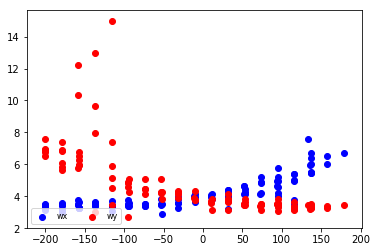

In [10]:
colors = ['b', 'r']

wx_plot = plt.scatter(z[0:100], w_x[0:100], marker='o', c=colors[0], edgecolors = 'face')
wy_plot = plt.scatter(z[0:100], w_y[0:100], marker='o', c=colors[1], edgecolors = 'face')

plt.legend((wx_plot, wy_plot),
           ('wx', 'wy'),
           scatterpoints=1,
           loc='lower left',
           ncol=3,
           fontsize=8)

plt.show()

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures

def quadratic_ransac_fit(x, y, name):
    x_ = x.reshape((-1, 1))
    y_ = y.reshape((-1, 1))

    xi = np.linspace(min(x), max(x), 100).reshape((-1, 1))

    poly_4 = PolynomialFeatures(degree=4)
    x_4 = poly_4.fit_transform(x_)
    xi_4 = poly_4.fit_transform(xi)

    m = linear_model.RANSACRegressor(linear_model.LinearRegression())
    m.fit(x_4, y_)
    yi = m.predict(xi_4)
    c = m.estimator_.coef_
    yi_b = np.dot(c, xi_4.T).T

    # the coefficients dont include the x^0 term for some reason??
    c_b = np.array([float(yi[3][0] - yi_b[0]), c[0, 1], c[0, 2], c[0, 3], c[0, 4]])
    yi_b = np.dot(c_b, xi_4.T).T

    inlier_mask = m.inlier_mask_
    outlier_mask = np.logical_not(inlier_mask)

    plt.figure(1)
    plt.plot(x[inlier_mask], y[inlier_mask], 'k.', label='data')
    plt.plot(x[outlier_mask], y[outlier_mask], 'r.', label='data (outliers)')
    plt.plot(xi, yi, label='quadratic ransac')
    # plt.plot(xi, yi_b, 'r--')
    plt.title('%s: %0.5f + %0.5fx + %0.5fx^2 + %0.5fx^3 + %0.5fx^4' % (name, c_b[0], c_b[1], c_b[2], c_b[3], c_b[4]))
    plt.legend()
    
    plt.figure(2)
    plt.plot(x[inlier_mask], y[inlier_mask], 'k.', label='data')
    plt.plot(xi, yi, label='quadratic ransac')
    plt.legend()

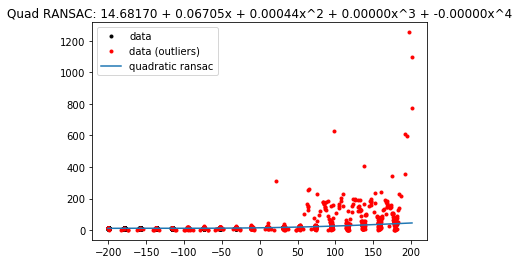

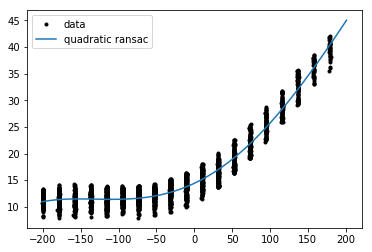

In [12]:
x, y = z, w_x**2
quadratic_ransac_fit(x, y, 'Quad RANSAC')

plt.show()

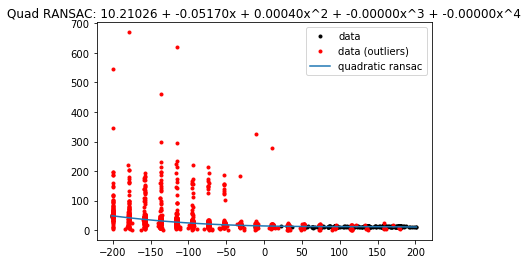

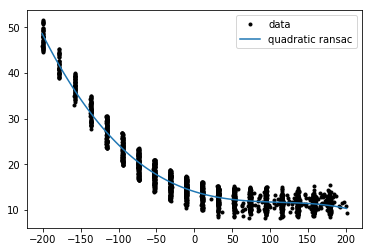

In [13]:
x, y = z, w_y**2
quadratic_ransac_fit(x, y, 'Quad RANSAC')

plt.show()